<center>
    <h1>Identifying the Human Values behind Arguments</h1>
    <h1>02 - LSTM Baseline Model</h1>
    <h2>Natural Language Processing</h2>
    <h3>Antonio Politano, Enrico Pittini, Riccardo Spolaor and Samuele Bortolato</h3>
    <h4>antonio.politano2@studio.unibo.it, enrico.pittini@studio.unibo.it, riccardo.spolaor@studio.unibo.it, samuele.bortolato@studio.unibo.it</h4>
</center>

---

In this notebook a *LSTM Baseline Model* is proposed for the *Identifying the Human Values behind Arguments* task and it is evaluated on the provided dataset.

For more detailed informations about the used functions, look into the corresponding docstrings inside the python files, inside the `src` folder.

In [1]:
# Settings for autoreloading.

%load_ext autoreload
%autoreload 2

In [2]:
# Settings for reproducibility.

from src.utils.seeder import set_random_seed

SEED = 42
set_random_seed(SEED)

## Download of the Dataset

In [3]:
from src.datasets.dataset_builder import get_dataframes

arguments_train_df, labels_train_df = get_dataframes('data', 'training')
arguments_test_df, labels_test_df = get_dataframes('data', 'validation')

In [4]:
TARGETS = labels_train_df.columns.to_list()

In [5]:
from src.datasets.dataset_builder import split_dataframes

(arguments_train_df, labels_train_df), (arguments_val_df, labels_val_df) = \
    split_dataframes(arguments_train_df, labels_train_df, seed=SEED)

# Model and Tokenizer Definition

In [6]:
from torch import cuda
from transformers import logging

DEVICE = 'cuda' if cuda.is_available() else 'cpu'

# Set verbosity at "error" level
logging.set_verbosity_error()

In [7]:
from src.embeddings.embedding_matrix import load_embedding_model

# Set the dimension of the embeddings to load.
EMBEDDING_DIMENSION = 100

# Get the GLOVE embeddings.
GLOVE_embeddings = load_embedding_model(folder_path='./data',
                                        embedding_dim=EMBEDDING_DIMENSION)

In [8]:
from src.embeddings.vocabulary import get_texts_from_arguments_dataframes

# Build a dictionary to encde the stance.
stance_encoder = { 'in favor of': '[FAV]', 'against': '[AGN]' }

# Get a list of all the sentences in the datasets in the form
# '<premise> [FAV]/[AGN] <conclusion>'
texts = get_texts_from_arguments_dataframes(
    stance_encoder, arguments_train_df, arguments_val_df, arguments_test_df)

In [9]:
from src.embeddings.vocabulary import get_vocabulary

# Get the vocabulary and the tokenizer.
vocabulary, tokenizer = get_vocabulary(texts)

In [10]:
print('The length of the vocabuary is:', len(vocabulary))

The length of the vocabuary is: 9683


In [11]:
from src.embeddings.embedding_matrix import build_embedding_matrix

# Get the embedding matrix from GLOVE and the given vocabulary.
embedding_matrix = build_embedding_matrix(
    vocabulary=vocabulary, GLOVE_embeddings=GLOVE_embeddings,
    embedding_dimension=EMBEDDING_DIMENSION)

In [12]:
from src.models.lstm_model import LSTM

model = LSTM(DEVICE, embedding_matrix, len(TARGETS))

In [13]:
print('Model structure:')
print(model)

Model structure:
LSTM(
  (embedding_layer): Embedding(9683, 100)
  (lstm_layer): LSTM(100, 128, num_layers=2, batch_first=True)
  (classification_layer): Linear(in_features=128, out_features=20, bias=True)
)


## Training

### Create Dataloaders

In [14]:
from src.datasets.dataloader_builder import get_dataloader

BATCH_SIZE_TRAIN = 8
BATCH_SIZE_EVAL = 16

train_loader = get_dataloader(arguments_train_df, labels_train_df, tokenizer,
                             stance_encoder, is_transformer=False, 
                             batch_size=BATCH_SIZE_TRAIN, shuffle=True,
                             use_augmentation=True)
val_loader = get_dataloader(arguments_val_df, labels_val_df, tokenizer,
                             stance_encoder, is_transformer=False,
                             batch_size=BATCH_SIZE_EVAL, shuffle=False,
                             use_augmentation=False)
test_loader = get_dataloader(arguments_test_df, labels_test_df, tokenizer,
                             stance_encoder, is_transformer=False,
                             batch_size=BATCH_SIZE_EVAL, shuffle=False,
                             use_augmentation=False)

### Training parameters

In [15]:
import os
from torch.optim import Adam
from src.training.training_utils import Checkpoint, EarlyStopping, FocalLoss

# Set the number of epochs.
EPOCHS = 20
# Set the learning rate.
LEARNING_RATE = 1e-03
# Set how many training steps to use for validation.
STEPS_VALIDATE = 200

# Set the loss function.
train_labels_frequencies = (labels_train_df.sum() / len(labels_train_df))
train_labels_frequencies = train_labels_frequencies.to_numpy()
loss_function = FocalLoss(alpha=train_labels_frequencies, gamma=1.5)

# Set the optimizer.
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

# Set the checkpoints and the early stopping monitor.
checkpoint = Checkpoint(model, path=os.path.join('models',
                                                 'lstm_baseline.pth'))
early_stopping = EarlyStopping()

### Training

In [16]:
from src.training.training import train

# Train the model.
train_loss_history, val_loss_history, val_f1_macro_history = train(
    train_loader, val_loader, model, optimizer, loss_function, DEVICE,
    epochs=EPOCHS, steps_validate=STEPS_VALIDATE, checkpoint=checkpoint,
    early_stopping=early_stopping, reload_best_weights=True,
    use_threshold_selection=True)

epoch: 1/20, 199/540, 4s 20ms/step, loss: 0.0637                
validate: 0s, validation loss: 0.0634, validation f1 macro: 28.2 %                
epoch: 1/20, 399/540, 7s 18ms/step, loss: 0.0635                
validate: 0s, validation loss: 0.0633, validation f1 macro: 29 %                
epoch: 1/20, 540/540, 9s 17ms/step, loss: 0.0636                
---------------------------------------------------------------
epoch: 1/20, 9s, loss: 0.0636, val loss:, 0.0631, val f1 macro: 31 %
epoch: 2/20, 199/540, 3s 14ms/step, loss: 0.0625                
validate: 0s, validation loss: 0.0632, validation f1 macro: 32.1 %                
epoch: 2/20, 399/540, 6s 15ms/step, loss: 0.0622                
validate: 0s, validation loss: 0.0614, validation f1 macro: 33.4 %                
epoch: 2/20, 540/540, 8s 15ms/step, loss: 0.0622                
---------------------------------------------------------------
epoch: 2/20, 8s, loss: 0.0622, val loss:, 0.0612, val f1 macro: 33.4 %
epoch: 3/20,

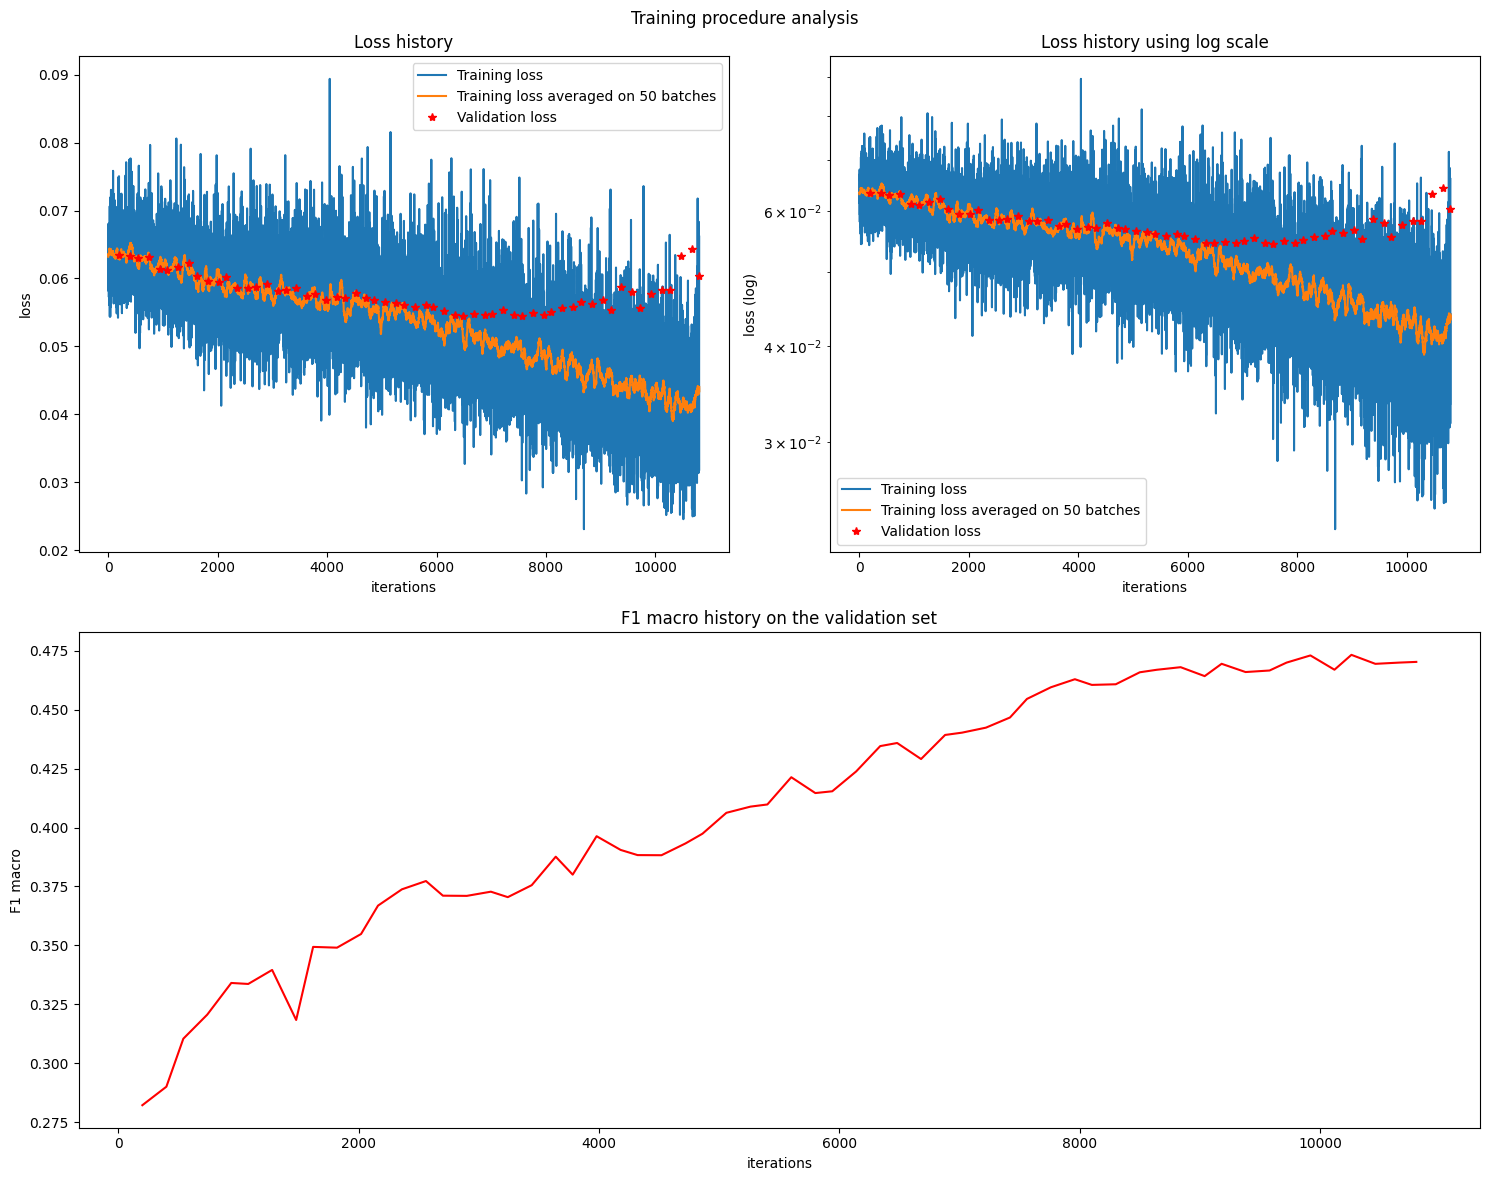

In [17]:
from src.training.training_analysis import plot_training_history

plot_training_history(train_loss_history, val_loss_history,
                      val_f1_macro_history)

# Model Evaluation

## Threshold selection

Macro-averaged One-vs-Rest ROC AUC score:
0.77


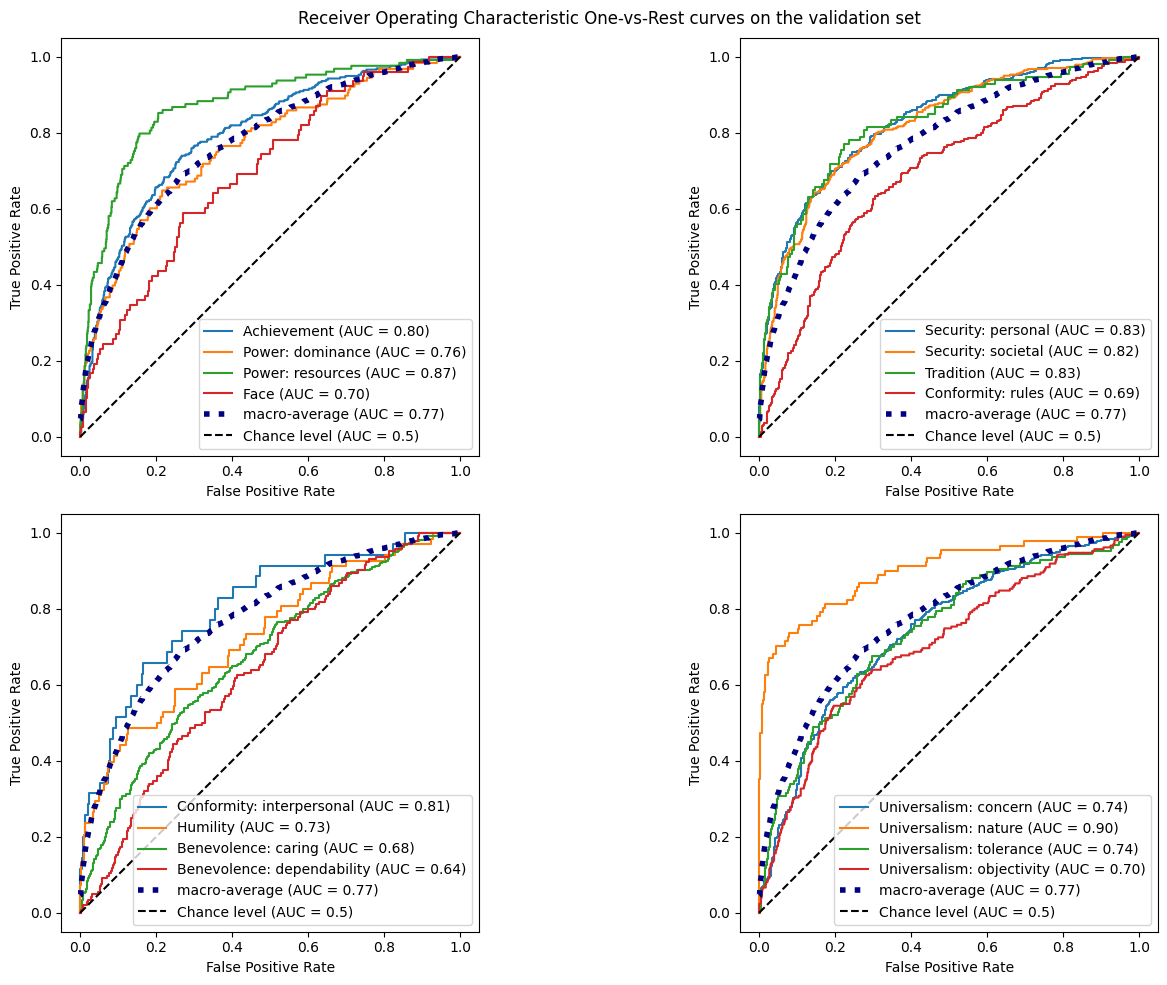

In [18]:
from src.evaluation.evaluation import get_dataset_prediction_scores
from src.evaluation.evaluation_analysis import plot_roc_curves

y_scores, y_true = get_dataset_prediction_scores(model, val_loader, DEVICE)
plot_roc_curves(y_true, y_scores, TARGETS, 'validation')

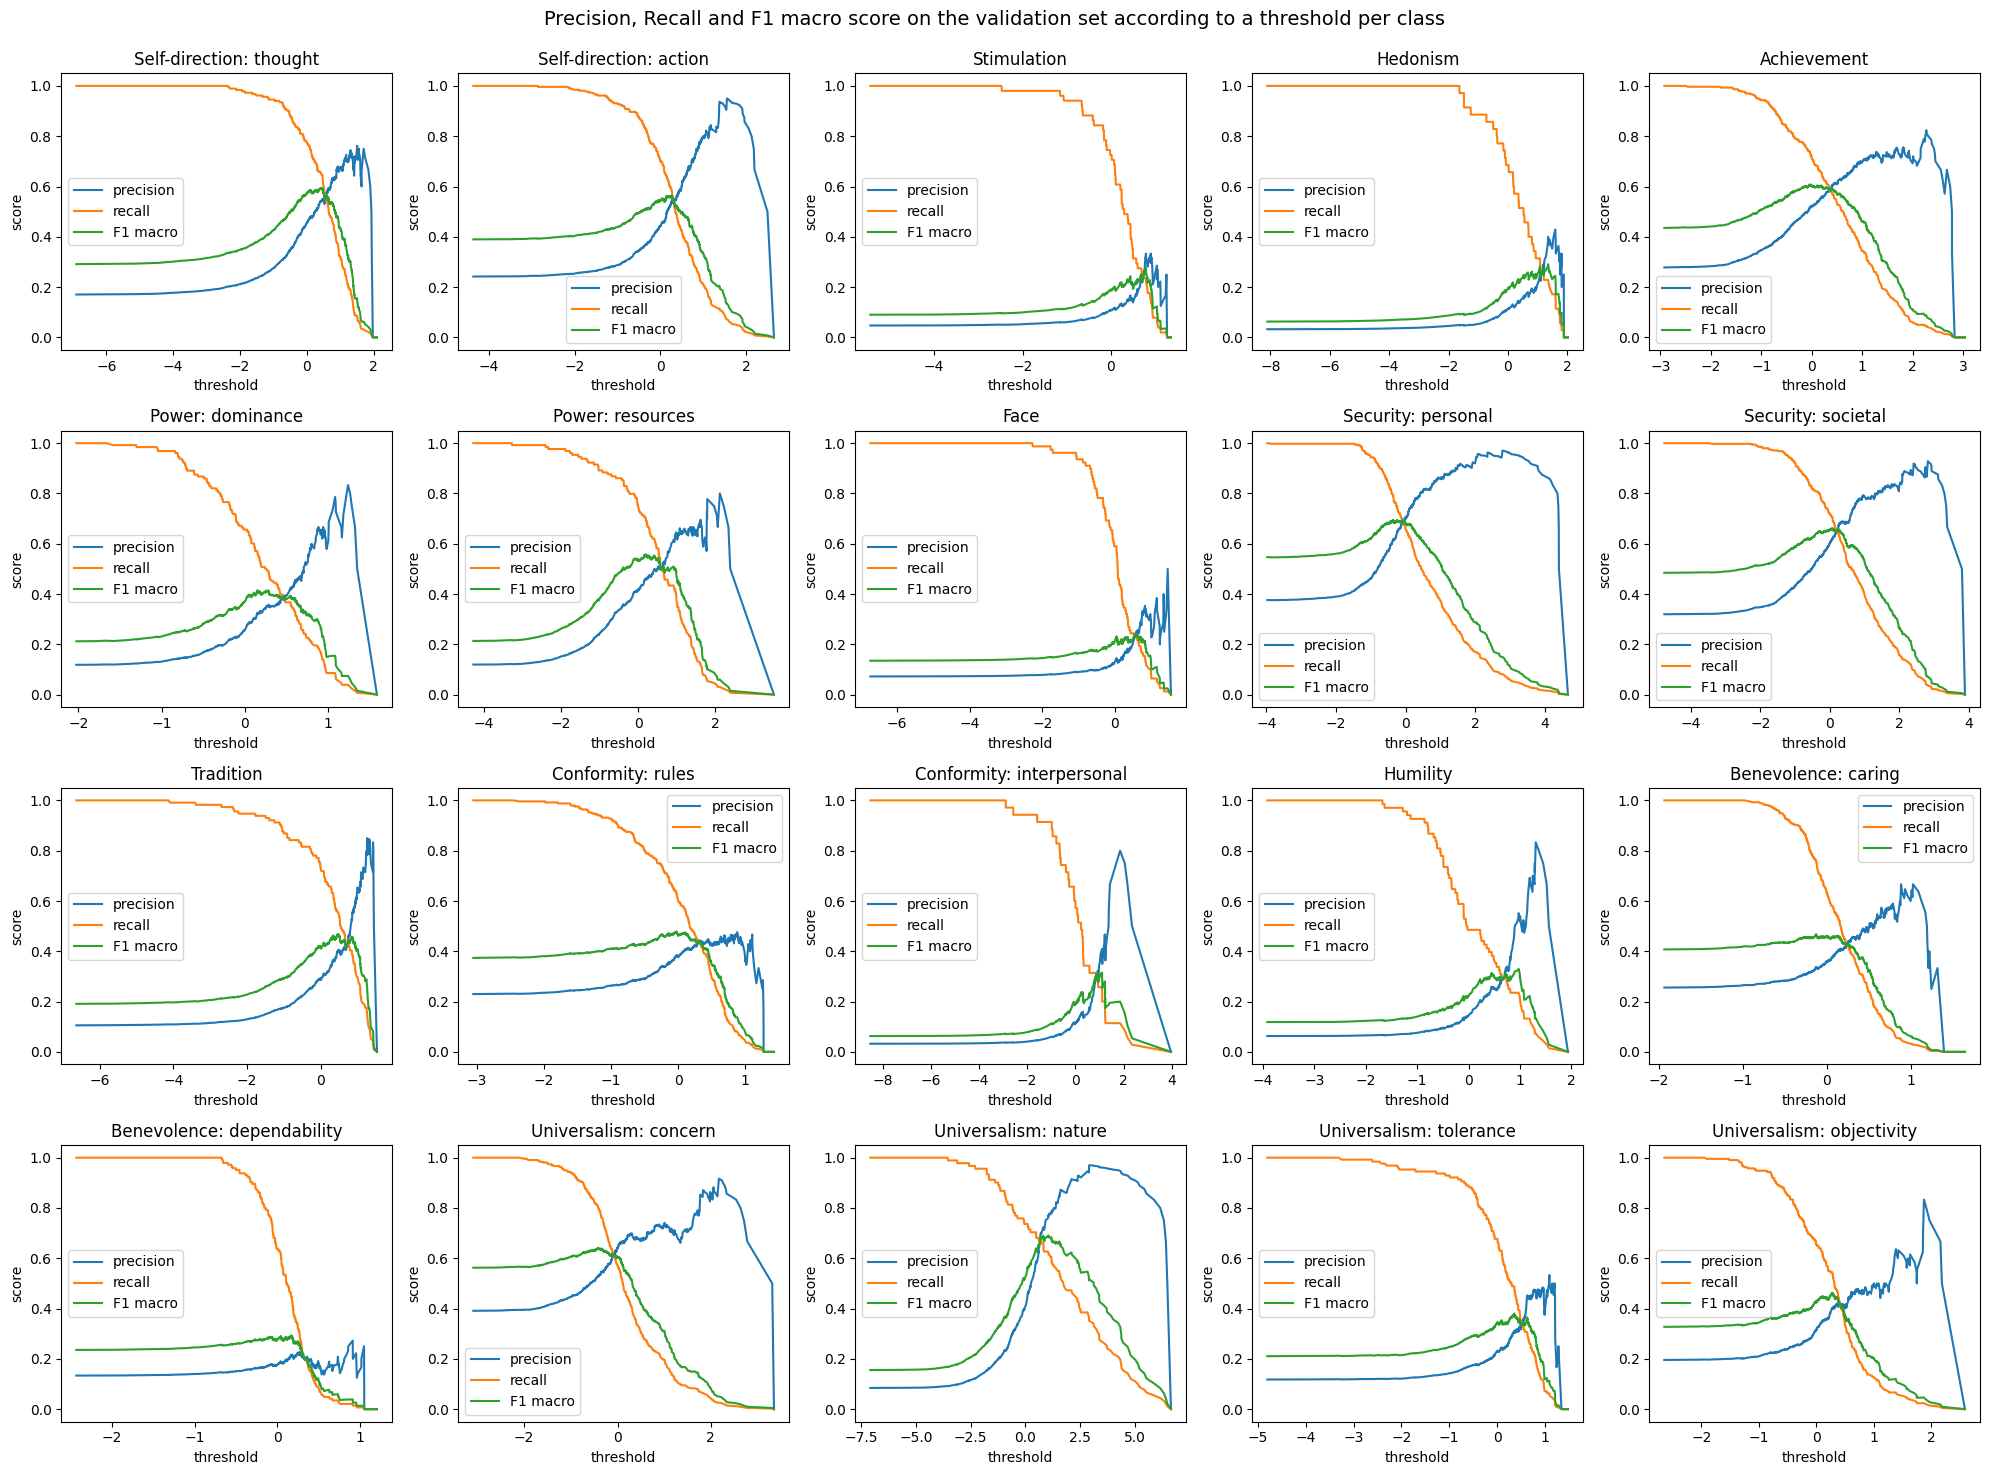

In [19]:
from src.evaluation.evaluation_analysis import (
    plot_precision_recall_f1_macro_curves)

plot_precision_recall_f1_macro_curves(y_true, y_scores, TARGETS, 'validation')

In [20]:
from src.evaluation.evaluation import get_best_thresholds
import numpy as np

# Get the best thresholds.
thresholds_per_target = get_best_thresholds(y_true, y_scores)

# Save the best thresholds.
np.save(os.path.join('models', 'lstm_baseline_thresholds.npy'),
        thresholds_per_target)

for target, thresh in zip(TARGETS, thresholds_per_target):
    print(f'"{target}" best threshold: {thresh:.4f}')

"Self-direction: thought" best threshold: 0.4097
"Self-direction: action" best threshold: 0.2540
"Stimulation" best threshold: 0.7920
"Hedonism" best threshold: 1.3529
"Achievement" best threshold: -0.0416
"Power: dominance" best threshold: 0.1492
"Power: resources" best threshold: 0.1923
"Face" best threshold: 0.5964
"Security: personal" best threshold: -0.2519
"Security: societal" best threshold: 0.0759
"Tradition" best threshold: 0.4719
"Conformity: rules" best threshold: -0.0295
"Conformity: interpersonal" best threshold: 1.1026
"Humility" best threshold: 0.9727
"Benevolence: caring" best threshold: -0.1283
"Benevolence: dependability" best threshold: 0.1779
"Universalism: concern" best threshold: -0.4287
"Universalism: nature" best threshold: 1.0470
"Universalism: tolerance" best threshold: 0.3622
"Universalism: objectivity" best threshold: 0.2719


## Evaluation on the Validation set

In [21]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, val_loader, DEVICE)

# Compute Validation F1 macro score.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the validation set with base threshold 0:', 
      f'{f1_macro:.3f}')

Validation f1-score macro on the validation set with base threshold 0: 0.425


In [22]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, val_loader, DEVICE,
                                         thresholds_per_target)

# Compute Validation F1 macro score with threshold selection.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the validation set with threshold',
      f'selection: {f1_macro:.3f}')

Validation f1-score macro on the validation set with threshold selection: 0.473


In [23]:
from src.evaluation.evaluation_analysis import print_classification_report

print_classification_report(y_true, y_pred, TARGETS, 'validation')

Classification report for the validation set:
                            precision    recall  f1-score   support

   Self-direction: thought       0.55      0.66      0.60       184
    Self-direction: action       0.54      0.59      0.56       261
               Stimulation       0.34      0.24      0.28        51
                  Hedonism       0.42      0.23      0.30        35
               Achievement       0.52      0.74      0.61       300
          Power: dominance       0.33      0.57      0.42       128
          Power: resources       0.46      0.71      0.56       129
                      Face       0.26      0.23      0.24        78
        Security: personal       0.65      0.75      0.69       406
        Security: societal       0.62      0.71      0.66       345
                 Tradition       0.41      0.55      0.47       114
         Conformity: rules       0.38      0.63      0.48       249
 Conformity: interpersonal       0.43      0.26      0.32        35
 

## Evaluation on the Test set

In [24]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, test_loader, DEVICE)

# Compute Test F1 macro score.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the test set with base threshold 0:',
      f'{f1_macro:.3f}')

Validation f1-score macro on the test set with base threshold 0: 0.380


In [25]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, test_loader, DEVICE,
                                         thresholds_per_target)

# Compute Test F1 macro score with threshold selection.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the test set with threshold selection:',
      f'{f1_macro:.3f}')

Validation f1-score macro on the test set with threshold selection: 0.373


In [26]:
from src.evaluation.evaluation_analysis import print_classification_report

print_classification_report(y_true, y_pred, TARGETS, 'test')

Classification report for the test set:
                            precision    recall  f1-score   support

   Self-direction: thought       0.35      0.50      0.41       251
    Self-direction: action       0.44      0.38      0.41       496
               Stimulation       0.31      0.24      0.27       138
                  Hedonism       0.20      0.14      0.16       103
               Achievement       0.52      0.61      0.56       575
          Power: dominance       0.23      0.41      0.30       164
          Power: resources       0.35      0.72      0.47       132
                      Face       0.20      0.18      0.19       130
        Security: personal       0.61      0.79      0.68       759
        Security: societal       0.55      0.59      0.57       488
                 Tradition       0.31      0.42      0.36       172
         Conformity: rules       0.37      0.64      0.47       455
 Conformity: interpersonal       0.00      0.00      0.00        60
       